<a href="https://colab.research.google.com/github/Shumookh/Hydro_Clean/blob/main/HydroClear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Load the dataset
df = pd.read_csv("/content/water_dataX.csv", encoding='latin-1') # Try 'latin-1' encoding
df


,Dissolvedoxygen,pH,Conductivity,Biologicaloxygendemand,Nitrate,Fecalcoliform,Totalcoliform
0,6.7,7.5,203,NAN,0.1,11,27
1,5.7,7.2,189,2,0.2,4953,8391
2,6.3,6.9,179,1.7,0.1,3243,5330
3,5.8,6.9,64,3.8,0.5,5382,8443
4,5.8,7.3,83,1.9,0.4,3428,5500
...,...,...,...,...,...,...,...
1986,7.9,738,7.2,2.7,0.518,0.518,202
1987,7.5,585,6.3,2.6,0.155,0.155,315
1988,7.6,98,6.2,1.2,NAN,NAN,570
1989,7.7,91,6.5,1.3,NAN,NAN,562


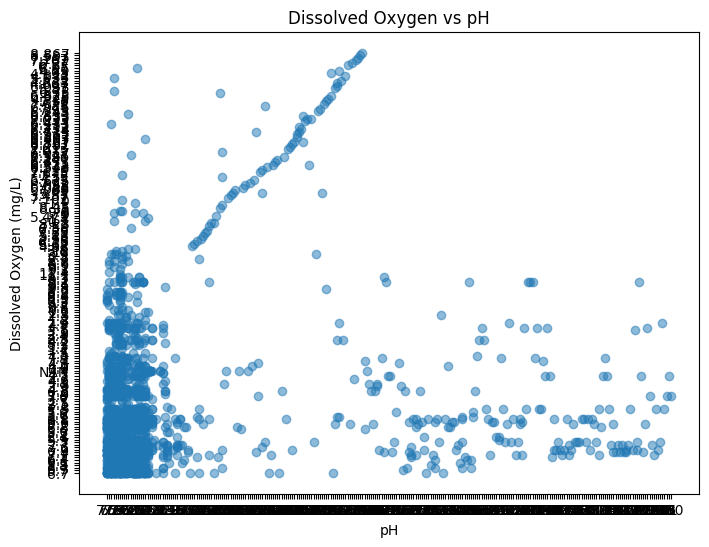

In [ ]:
# @title Dissolved Oxygen vs pH

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(df['pH'], df['Dissolvedoxygen'], alpha=0.5)
plt.xlabel('pH')
plt.ylabel('Dissolved Oxygen (mg/L)')
_ = plt.title('Dissolved Oxygen vs pH')

In [ ]:
# Step 2: Inspect the dataset
print("Dataset Overview:")
print(df.head())
print("\nColumn Data Types Before Conversion:")
#print(df.dtypes)

Dataset Overview:
  Dissolvedoxygen   pH Conductivity Biologicaloxygendemand Nitrate  \
0             6.7  7.5          203                    NAN     0.1   
1             5.7  7.2          189                      2     0.2   
2             6.3  6.9          179                    1.7     0.1   
3             5.8  6.9           64                    3.8     0.5   
4             5.8  7.3           83                    1.9     0.4   

  Fecalcoliform Totalcoliform  
0            11            27  
1          4953          8391  
2          3243          5330  
3          5382          8443  
4          3428          5500  

Column Data Types Before Conversion:


In [ ]:
# Step 3: Convert columns to numeric (forcing errors to NaN)
df_numeric = df.apply(pd.to_numeric, errors='coerce')

In [ ]:
# Step 4: Drop columns that are entirely NaN or empty
df_numeric = df_numeric.dropna(axis=1, how='all')


In [ ]:
# Re-check for any remaining non-numeric columns
print("\nColumn Data Types After Conversion:")
print(df_numeric.dtypes)



Column Data Types After Conversion:
Dissolvedoxygen           float64
pH                        float64
Conductivity              float64
Biologicaloxygendemand    float64
Nitrate                   float64
Fecalcoliform             float64
Totalcoliform             float64
dtype: object


In [ ]:
# Step 5: Ensure there are numeric columns left for processing
if df_numeric.empty:
    raise ValueError("No numeric columns available for processing after conversion and dropping non-numeric columns.")


In [ ]:
print("\nNumeric Columns Available for Processing:")
print(df_numeric.columns)



Numeric Columns Available for Processing:
Index(['Dissolvedoxygen', 'pH', 'Conductivity', 'Biologicaloxygendemand',
       'Nitrate', 'Fecalcoliform', 'Totalcoliform'],
      dtype='object')


In [ ]:
# Step 6: Handle missing values (if any) by imputing the mean
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

In [ ]:
# Check if DataFrame is empty after imputation
if df.empty:
    raise ValueError("The DataFrame is empty after imputation. Check the input data.")

In [ ]:
# Step 7: Normalize the data using Z-score
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_imputed.columns)

print("\nData after Z-score Normalization:")
print(df_normalized.head())


Data after Z-score Normalization:
   Dissolvedoxygen        pH  Conductivity  Biologicaloxygendemand   Nitrate  \
0         0.232467 -0.055791     -0.287073                0.000000 -0.395468   
1        -0.523859 -0.055951     -0.289611               -0.169917 -0.369503   
2        -0.070063 -0.056111     -0.291424               -0.180235 -0.395468   
3        -0.448226 -0.056111     -0.312273               -0.108004 -0.291608   
4        -0.448226 -0.055898     -0.308828               -0.173356 -0.317573   

   Fecalcoliform  Totalcoliform  
0      -0.045107      -0.038810  
1      -0.044492      -0.038202  
2      -0.044705      -0.038424  
3      -0.044439      -0.038198  
4      -0.044682      -0.038412  


In [ ]:
# Define the ideal values and permissible limits for each parameter
ideal_values = {
    'Dissolvedoxygen': 14.6,
    'pH': 7.0,
    'Conductivity': 0,
    'Biologicaloxygendemand': 0,
    'Nitrate': 0,
    'Fecalcoliform': 0,
    'Totalcoliform': 0
}

permissible_limits = {
    'Dissolvedoxygen': 10,
    'pH': 8.5,
    'Conductivity': 1000,
    'Biologicaloxygendemand': 5,
    'Nitrate': 45,
    'Fecalcoliform': 100,
    'Totalcoliform': 1000
}
# Number of parameters
N = len(permissible_limits)

# Calculate the constant of proportionality K
K = 1 / sum(permissible_limits.values())

# Function to calculate quality estimate qi
def calculate_qi(Vi, VIdeal, Si):
    return 100 * (Vi - VIdeal) / (Si - VIdeal)

# Function to calculate unit weight wi
def calculate_wi(Si, K):
    return K / Si

# Calculate WQI for each row
def calculate_wqi(row):
    q_values = []
    w_values = []
    for param in permissible_limits:
        Vi = row.get(param, np.nan)
        VIdeal = ideal_values.get(param, 0)
        Si = permissible_limits.get(param, 0)
        qi = calculate_qi(Vi, VIdeal, Si)
        wi = calculate_wi(Si, K)
        q_values.append(qi)
        w_values.append(wi)

    # Compute WQI
    numerator = sum(qi * wi for qi, wi in zip(q_values, w_values))
    denominator = sum(w_values)
    return numerator / denominator if denominator != 0 else np.nan

df_normalized['WQI'] = df_normalized.apply(calculate_wqi, axis=1)

# Display the calculated WQI
print("\nData with WQI:")
print(df_normalized.head(20))



Data with WQI:
    Dissolvedoxygen        pH  Conductivity  Biologicaloxygendemand   Nitrate  \
0          0.232467 -0.055791     -0.287073                0.000000 -0.395468   
1         -0.523859 -0.055951     -0.289611               -0.169917 -0.369503   
2         -0.070063 -0.056111     -0.291424               -0.180235 -0.395468   
3         -0.448226 -0.056111     -0.312273               -0.108004 -0.291608   
4         -0.448226 -0.055898     -0.308828               -0.173356 -0.317573   
5         -0.675124 -0.055845     -0.309191               -0.187115 -0.395468   
6         -0.221329 -0.056218     -0.268037               -0.190554 -0.343538   
7          0.005569 -0.056218     -0.248820               -0.204313 -0.369503   
8          0.005569 -0.055738     -0.268581               -0.163038 -0.395468   
9         -0.070063 -0.055738     -0.309916               -0.159598 -0.395468   
10         0.534997 -0.056005     -0.291968               -0.197433 -0.395468   
11         0

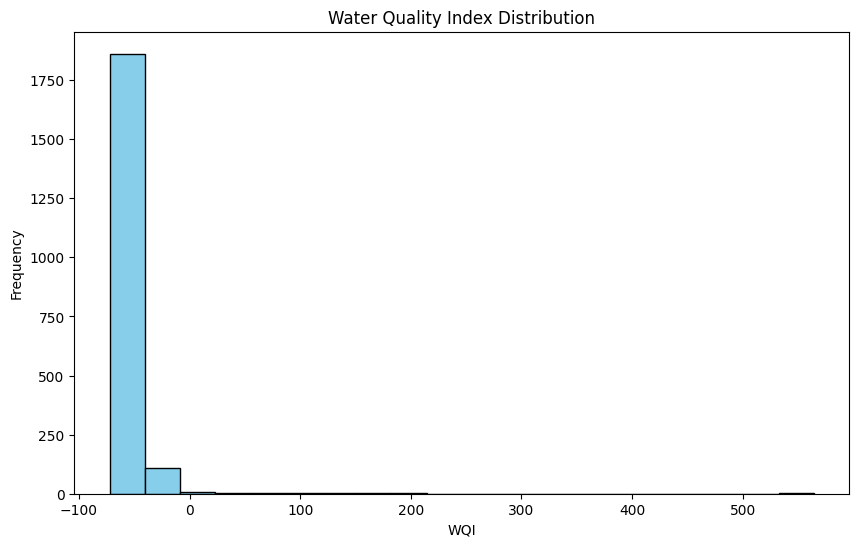

In [ ]:

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(df_normalized['WQI'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Water Quality Index Distribution')
plt.xlabel('WQI')
plt.ylabel('Frequency')
plt.show()

K (constant of proportionality): 309.7857142857143

Data with WQI:
   Dissolvedoxygen        pH  Conductivity  Biologicaloxygendemand   Nitrate  \
0         0.232467 -0.055791     -0.287073                0.000000 -0.395468   
1        -0.523859 -0.055951     -0.289611               -0.169917 -0.369503   
2        -0.070063 -0.056111     -0.291424               -0.180235 -0.395468   
3        -0.448226 -0.056111     -0.312273               -0.108004 -0.291608   
4        -0.448226 -0.055898     -0.308828               -0.173356 -0.317573   

   Fecalcoliform  Totalcoliform        WQI  
0      -0.045107      -0.038810 -53.391069  
1      -0.044492      -0.038202 -51.256488  
2      -0.044705      -0.038424 -53.536629  
3      -0.044439      -0.038198 -51.066564  
4      -0.044682      -0.038412 -51.644206  


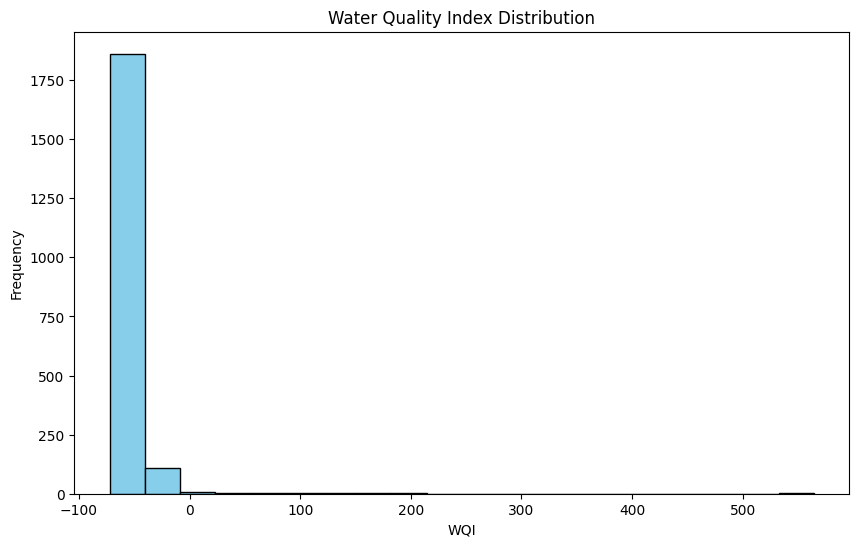

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Step 1: Load the dataset
df = pd.read_csv("/content/water_dataX.csv", encoding='latin-1') # Try 'latin-1' encoding

# Step 2: Convert columns to numeric (forcing errors to NaN)
df_numeric = df.apply(pd.to_numeric, errors='coerce')

# Drop columns that are entirely NaN or empty
df_numeric = df_numeric.dropna(axis=1, how='all')

# Handle missing values by imputing the mean
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

# Normalize the data using Z-score
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_imputed.columns)

# Define the ideal values and permissible limits for each parameter
ideal_values = {
    'Dissolvedoxygen': 14.6,
    'pH': 7.0,
    'Conductivity': 0,
    'Biologicaloxygendemand': 0,
    'Nitrate': 0,
    'Fecalcoliform': 0,
    'Totalcoliform': 0
}

permissible_limits = {
    'Dissolvedoxygen': 10,
    'pH': 8.5,
    'Conductivity': 1000,
    'Biologicaloxygendemand': 5,
    'Nitrate': 45,
    'Fecalcoliform': 100,
    'Totalcoliform': 1000
}

# Number of parameters
N = len(permissible_limits)

# Calculate the constant of proportionality K
K = 1 / N * sum(permissible_limits.values())
print(f"K (constant of proportionality): {K}")

# Function to calculate quality estimate qi
def calculate_qi(Vi, VIdeal, Si):
    if Si == VIdeal:
        return np.nan  # Avoid division by zero
    return 100 * (Vi - VIdeal) / (Si - VIdeal)

# Function to calculate unit weight wi
def calculate_wi(Si, K):
    if Si == 0:
        return np.nan  # Avoid division by zero
    return K / Si

# Calculate WQI for each row
def calculate_wqi(row):
    q_values = []
    w_values = []
    for param in permissible_limits:
        Vi = row.get(param, np.nan)
        VIdeal = ideal_values.get(param, 0)
        Si = permissible_limits.get(param, 0)

        if pd.isna(Vi) or Si == 0:
            continue  # Skip if necessary values are missing or invalid

        qi = calculate_qi(Vi, VIdeal, Si)
        wi = calculate_wi(Si, K)

        if pd.notna(qi) and pd.notna(wi):
            q_values.append(qi)
            w_values.append(wi)

    if not q_values or not w_values:
        return np.nan  # Return NaN if no valid values were found

    # Compute WQI
    numerator = sum(qi * wi for qi, wi in zip(q_values, w_values))
    denominator = sum(w_values)

    if denominator == 0:
        return np.nan  # Avoid division by zero

    return numerator / denominator

df_normalized['WQI'] = df_normalized.apply(calculate_wqi, axis=1)

# Display the calculated WQI
print("\nData with WQI:")
print(df_normalized.head())

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(df_normalized['WQI'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Water Quality Index Distribution')
plt.xlabel('WQI')
plt.ylabel('Frequency')
plt.show()


Streaming output truncated to the last 5000 lines.
Param: Fecalcoliform, qi: 518.0, wi: 4.6114825916532164e-06
Param: Totalcoliform, qi: 91.8, wi: 4.611482591653217e-07
Param: Dissolvedoxygen, qi: 156.52173913043478, wi: 4.6114825916532166e-05
Param: pH, qi: 0.0, wi: 5.4252736372390786e-05
Param: Conductivity, qi: 4.5, wi: 4.611482591653217e-07
Param: Biologicaloxygendemand, qi: 22.000000000000004, wi: 9.222965183306433e-05
Param: Nitrate, qi: 0.24444444444444444, wi: 1.0247739092562704e-05
Param: Fecalcoliform, qi: 1043.0, wi: 4.6114825916532164e-06
Param: Totalcoliform, qi: 193.3, wi: 4.611482591653217e-07
Param: Dissolvedoxygen, qi: 152.17391304347828, wi: 4.6114825916532166e-05
Param: pH, qi: -19.99999999999999, wi: 5.4252736372390786e-05
Param: Conductivity, qi: 5.2, wi: 4.611482591653217e-07
Param: Biologicaloxygendemand, qi: 22.000000000000004, wi: 9.222965183306433e-05
Param: Nitrate, qi: 0.24444444444444444, wi: 1.0247739092562704e-05
Param: Fecalcoliform, qi: 613.0, wi: 4.611

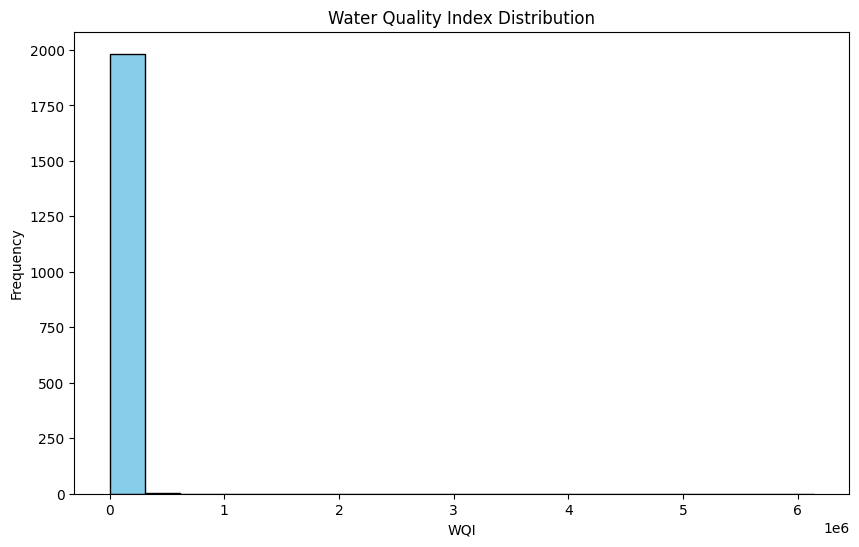

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Step 1: Load the dataset
df = pd.read_csv("/content/water_dataX.csv", encoding='latin-1')  # Use 'latin-1' encoding

# Step 2: Convert columns to numeric (forcing errors to NaN)
df_numeric = df.apply(pd.to_numeric, errors='coerce')

# Drop columns that are entirely NaN or empty
df_numeric = df_numeric.dropna(axis=1, how='all')

# Handle missing values by imputing the mean
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)


# Define the ideal values and permissible limits for each parameter
ideal_values = {
    'Dissolvedoxygen': 14.6,
    'pH': 7.0,
    'Conductivity': 0,
    'Biologicaloxygendemand': 0,
    'Nitrate': 0,
    'Fecalcoliform': 0,
    'Totalcoliform': 0
}

permissible_limits = {
    'Dissolvedoxygen': 10,
    'pH': 8.5,
    'Conductivity': 1000,
    'Biologicaloxygendemand': 5,
    'Nitrate': 45,
    'Fecalcoliform': 100,
    'Totalcoliform': 1000
}

# Number of parameters
N = len(permissible_limits)

# Calculate the constant of proportionality K
K = 1 / sum(permissible_limits.values())
print(f"K (constant of proportionality): {K}")

# Function to calculate quality estimate qi
def calculate_qi(Vi, V_ideal, S_i):
    if S_i == V_ideal:
        return np.nan  # Avoid division by zero
    return 100 * (Vi - V_ideal) / (S_i - V_ideal)

# Function to calculate unit weight wi
def calculate_wi(S_i, K):
    if S_i == 0:
        return np.nan  # Avoid division by zero
    return K / S_i

# Calculate WQI for each row
def calculate_wqi(row):
    q_values = []
    w_values = []
    for param in permissible_limits:
        Vi = row.get(param, np.nan)
        V_ideal = ideal_values.get(param, 0)
        S_i = permissible_limits.get(param, 0)

        if pd.isna(Vi) or S_i == 0:
            print(f"Skipping {param}: Vi={Vi}, S_i={S_i}")  # Debug output
            continue  # Skip if necessary values are missing or invalid

        qi = calculate_qi(Vi, V_ideal, S_i)
        wi = calculate_wi(S_i, K)

        print(f"Param: {param}, qi: {qi}, wi: {wi}")  # Debug output

        if pd.notna(qi) and pd.notna(wi):
            q_values.append(qi)
            w_values.append(wi)

    if not q_values or not w_values:
        print("No valid q or w values found!")  # Debug output
        return np.nan  # Return NaN if no valid values were found

    # Compute WQI
    numerator = sum(qi * wi for qi, wi in zip(q_values, w_values))
    denominator = sum(w_values)

    if denominator == 0:
        print("Denominator is zero!")  # Debug output
        return np.nan  # Avoid division by zero

    return numerator / denominator


# Apply the WQI calculation to each row
df_imputed['WQI'] = df_imputed.apply(calculate_wqi, axis=1)

# Display the calculated WQI
print("\nData with WQI:")
print(df_imputed.head(50))

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(df_imputed['WQI'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Water Quality Index Distribution')
plt.xlabel('WQI')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Save the DataFrame with WQI to a CSV file
output_file_path = "/content/water_data_with_wqi.csv"  # Specify the desired output file path
df_imputed.to_csv(output_file_path, index=False)  # Save without the index
print(f"Data saved to {output_file_path}")

Data saved to /content/water_data_with_wqi.csv



Data with WQI:
   Dissolvedoxygen   pH  Conductivity  Biologicaloxygendemand  Nitrate  \
0              6.7  7.5         203.0                6.940049      0.1   
1              5.7  7.2         189.0                2.000000      0.2   
2              6.3  6.9         179.0                1.700000      0.1   
3              5.8  6.9          64.0                3.800000      0.5   
4              5.8  7.3          83.0                1.900000      0.4   

   Fecalcoliform  Totalcoliform         WQI  
0           11.0           27.0  108.423815  
1         4953.0         8391.0  175.363506  
2         3243.0         5330.0  126.135831  
3         5382.0         8443.0  195.105659  
4         3428.0         5500.0  141.393246  
Data saved to /content/water_data_with_wqi.csv


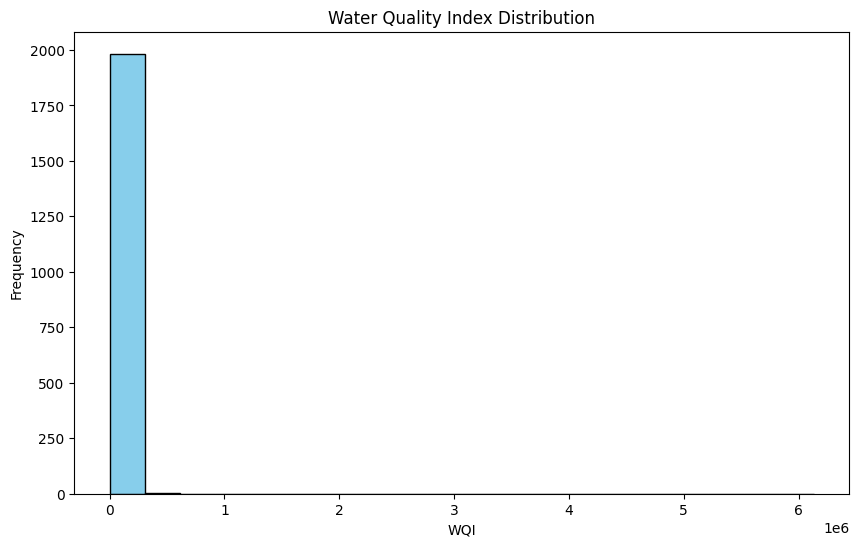

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import os # accessing directory structure

# Step 1: Load the dataset
df = pd.read_csv("/content/water_dataX.csv", encoding='latin-1')  # Use 'latin-1' encoding

# Step 2: Convert columns to numeric (forcing errors to NaN)
df_numeric = df.apply(pd.to_numeric, errors='coerce')

# Drop columns that are entirely NaN or empty
df_numeric = df_numeric.dropna(axis=1, how='all')

# Handle missing values by imputing the mean
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

# Step 3: Normalize the data using Z-score
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_imputed.columns)

# Define the ideal values and permissible limits for each parameter
ideal_values = {
    'Dissolvedoxygen': 14.6,
    'pH': 7.0,
    'Conductivity': 0,
    'Biologicaloxygendemand': 0,
    'Nitrate': 0,
    'Fecalcoliform': 0,
    'Totalcoliform': 0
}

permissible_limits = {
    'Dissolvedoxygen': 10,
    'pH': 8.5,
    'Conductivity': 1000,
    'Biologicaloxygendemand': 5,
    'Nitrate': 45,
    'Fecalcoliform': 100,
    'Totalcoliform': 1000
}

# Define the unit weights for each parameter
unit_weights = {
    'Dissolvedoxygen': 0.2213,
    'pH': 0.2604,
    'Conductivity': 0.0022,
    'Biologicaloxygendemand': 0.4426,
    'Nitrate': 0.0492,
    'Fecalcoliform': 0.0221,
    'Totalcoliform': 0.0022
}

# Calculate WQI for each row
def calculate_wqi(row):
    q_values = []
    w_values = []
    for param in permissible_limits:
        Vi = row.get(param, np.nan)
        V_ideal = ideal_values.get(param, 0)
        S_i = permissible_limits.get(param, 0)
        wi = unit_weights.get(param, 0)

        if pd.isna(Vi) or S_i == 0:
            continue  # Skip if necessary values are missing or invalid

        # Calculate quality estimate qi
        if S_i == V_ideal:
            qi = np.nan  # Avoid division by zero
        else:
            qi = 100 * (Vi - V_ideal) / (S_i - V_ideal)

        if pd.notna(qi):
            q_values.append(qi)
            w_values.append(wi)

    if not q_values or not w_values:
        return np.nan  # Return NaN if no valid values were found

    # Compute WQI
    numerator = sum(qi * wi for qi, wi in zip(q_values, w_values))
    denominator = sum(w_values)

    if denominator == 0:
        return np.nan  # Avoid division by zero

    return numerator / denominator

# Apply the WQI calculation to each row
df_imputed['WQI'] = df_imputed.apply(calculate_wqi, axis=1)
# Apply the WQI calculation to each row using the normalized data
df_normalized['WQI'] = df_normalized.apply(calculate_wqi, axis=1)

# Remove rows where WQI > 200
df_filtered = df_normalized[df_normalized['WQI'] <= 200]
# Display the calculated WQI
print("\nData with WQI:")
print(df_imputed.head(5))

# Save the DataFrame with WQI to a CSV file
output_file_path = "/content/water_data_with_wqi.csv"  # Specify the desired output file path
df_imputed.to_csv(output_file_path, index=False)  # Save without the index
print(f"Data saved to {output_file_path}")

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(df_imputed['WQI'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Water Quality Index Distribution')
plt.xlabel('WQI')
plt.ylabel('Frequency')
plt.show()